# Self-Stacking GroupCV XGBoost

In this notebook, I introduce a self-stacking XGBoost (XGB) pipeline. 

XGB model does not support multi-label learning so it cannot fully learn the label correlation as well as neural networks (NNs). Then I come up with an idea of self-stacking learning for XGB. The purpose is to enhance the label correlation learning by taking the first-stage predictions as additional features for the second-stage learning.

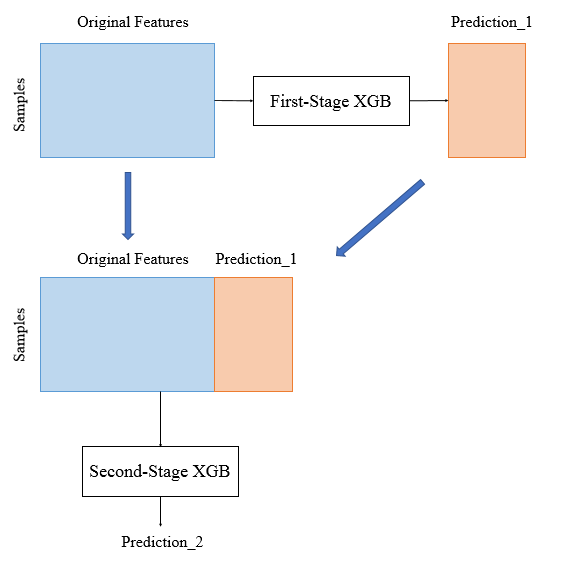

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import os
import gc
import pickle
import datetime
import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm.notebook import tqdm
from time import time

# Group CV

In [ ]:
def create_folds(num_starts, num_splits):
    
    folds = []
    
    # LOAD FILES
    train_feats = pd.read_csv('../input/lish-moa/train_features.csv')
    scored = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
    drug = pd.read_csv('/kaggle/input/lish-moa/train_drug.csv')
    scored = scored.loc[train_feats['cp_type'] == 'trt_cp', :]
    drug = drug.loc[train_feats['cp_type'] == 'trt_cp', :]
    targets = scored.columns[1:]
    scored = scored.merge(drug, on = 'sig_id', how = 'left') 

    # LOCATE DRUGS
    vc = scored.drug_id.value_counts()
    vc1 = vc.loc[vc <= 18].index.sort_values()
    vc2 = vc.loc[vc > 18].index.sort_values()
    
    for seed in range(num_starts):

        # STRATIFY DRUGS 18X OR LESS
        dct1 = {}; dct2 = {}
        skf = MultilabelStratifiedKFold(n_splits = num_splits, shuffle = True, random_state = seed)
        tmp = scored.groupby('drug_id')[targets].mean().loc[vc1]
        for fold,(idxT,idxV) in enumerate(skf.split(tmp,tmp[targets])):
            dd = {k:fold for k in tmp.index[idxV].values}
            dct1.update(dd)

        # STRATIFY DRUGS MORE THAN 18X
        skf = MultilabelStratifiedKFold(n_splits = num_splits, shuffle = True, random_state = seed)
        tmp = scored.loc[scored.drug_id.isin(vc2)].reset_index(drop = True)
        for fold,(idxT,idxV) in enumerate(skf.split(tmp,tmp[targets])):
            dd = {k:fold for k in tmp.sig_id[idxV].values}
            dct2.update(dd)

        # ASSIGN FOLDS
        scored['fold'] = scored.drug_id.map(dct1)
        scored.loc[scored.fold.isna(),'fold'] =\
            scored.loc[scored.fold.isna(),'sig_id'].map(dct2)
        scored.fold = scored.fold.astype('int8')
        folds.append(scored.fold.values)
        
        del scored['fold']
        
    return np.stack(folds)

# Data Preparation

In [ ]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')
test_features = pd.read_csv('../input/lish-moa/test_features.csv')

ss0 = pd.read_csv('../input/lish-moa/sample_submission.csv')
ss = pd.read_csv('../input/lish-moa/sample_submission.csv')

cols = [c for c in ss.columns.values if c != 'sig_id']
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]

In [ ]:
def preprocess(df):
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    del df['sig_id']
    return df

def log_loss_metric(y_true, y_pred):
    y_pred_clip = np.clip(y_pred, 1e-15, 1 - 1e-15)
    return - np.mean(y_true * np.log(y_pred_clip) + (1 - y_true) * np.log(1 - y_pred_clip))

train = preprocess(train_features)
test = preprocess(test_features)

del train_targets['sig_id']
del train_targets_nonscored['sig_id']

In [ ]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(n_quantiles = 100, output_distribution = 'normal', random_state = 42)
qt.fit(pd.concat([pd.DataFrame(train[GENES + CELLS]), pd.DataFrame(test[GENES + CELLS])]))
train[GENES + CELLS] = qt.transform(train[GENES + CELLS])
test[GENES + CELLS] = qt.transform(test[GENES + CELLS])

In [ ]:
from sklearn.decomposition import PCA

# GENES
n_comp_genes = 600  #<--Update

data = pd.concat([pd.DataFrame(train[GENES]), pd.DataFrame(test[GENES])])
pca_genes = PCA(n_components=n_comp_genes, random_state = 42)
data2 = pca_genes.fit_transform(data[GENES])
train2 = data2[:train.shape[0]]; test2 = data2[-test.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp_genes)])
test2 = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp_genes)])

train = pd.concat((train, train2), axis=1)
test = pd.concat((test, test2), axis=1)

#CELLS
n_comp_cells = 10  #<--Update

data = pd.concat([pd.DataFrame(train[CELLS]), pd.DataFrame(test[CELLS])])
pca_cells = PCA(n_components=n_comp_cells, random_state = 42)
data2 = pca_cells.fit_transform(data[CELLS])
train2 = data2[:train.shape[0]]; test2 = data2[-test.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp_cells)])
test2 = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp_cells)])

train = pd.concat((train, train2), axis=1)
test = pd.concat((test, test2), axis=1)

In [ ]:
from sklearn.feature_selection import VarianceThreshold

var_thresh = VarianceThreshold(0.8)  #<-- Update
data = train.append(test)
data_transformed = var_thresh.fit_transform(data.iloc[:, 3:])

train_transformed = data_transformed[ : train.shape[0]]
test_transformed = data_transformed[-test.shape[0] : ]

train = pd.DataFrame(train[['cp_type','cp_time','cp_dose']].values.reshape(-1, 3),\
            columns=['cp_type','cp_time','cp_dose'])

train = pd.concat([train, pd.DataFrame(train_transformed)], axis=1)

test = pd.DataFrame(test[['cp_type','cp_time','cp_dose']].values.reshape(-1, 3),\
            columns=['cp_type','cp_time','cp_dose'])

test = pd.concat([test, pd.DataFrame(test_transformed)], axis=1)

print(train.shape)
print(test.shape)

In [ ]:
train_targets = train_targets.loc[train['cp_type'] == 0].reset_index(drop = True)
train_targets_nonscored = train_targets_nonscored.loc[train['cp_type'] == 0].reset_index(drop = True)
train = train.loc[train['cp_type'] == 0].reset_index(drop = True)

print(train.shape)

In [ ]:
top_feats = np.arange(1, train.shape[1])
print(len(top_feats))

In [ ]:
train.head()

# XGB

In [ ]:
param = {'objective': 'binary:logistic',
         'eval_metric': 'logloss', 
         'tree_method': 'gpu_hist', 
#          'tree_method': 'auto',
#          'nthread': 4,
         'verbosity': 0, 
         'colsample_bytree': 0.1818593017814899, 
         'eta': 0.012887963193108452, 
         'gamma': 6.576022976359221, 
         'max_depth': 8, 
         'min_child_weight': 8.876744371188476, 
         'subsample': 0.7813380253086911, 
        }

In [ ]:
N_STARTS = 1
N_SPLITS = 5
LBS = 0.001

folds = create_folds(N_STARTS, N_SPLITS)
print(folds)

# First Stage

In [ ]:
ss0.loc[:, train_targets.columns] = 0
ss = ss0.copy()

res0 = train_targets.copy()
res0.loc[:, train_targets.columns] = 0
res = res0.copy()

for nums, seed in enumerate(range(N_STARTS)):
    start_time_seed = time()
    mean_score = 0
    param['random_state'] = seed
    for n, foldno in enumerate(set(folds[nums])):
        start_time_fold = time()
        tr = folds[nums] != foldno
        te = folds[nums] == foldno
        
        start_time_fold = time()
        x_tr, x_val = train.values[tr][:, top_feats], train.values[te][:, top_feats]
        y_tr, y_val = train_targets.values[tr], train_targets.values[te]
        x_tt = test.values[:, top_feats]
        
        # Label Smoothing
        y_tr = y_tr * (1 - LBS) + 0.5 * LBS
            
        val_predict = np.zeros(train_targets.shape)
        
        for tar in tqdm(range(train_targets.shape[1])):
            
            y_tr_tar, y_val_tar = y_tr[:, tar], y_val[:, tar]
            
            xgb_tr = xgb.DMatrix(x_tr, label = y_tr_tar, nthread = -1)
            xgb_val = xgb.DMatrix(x_val, label = y_val_tar, nthread = -1)
            xgb_tt = xgb.DMatrix(x_tt, nthread = -1)
            
            model = xgb.train(param, xgb_tr, 1000, [(xgb_val, 'eval')], early_stopping_rounds = 25, verbose_eval = 0)
                        
            test_predict = model.predict(xgb_tt, ntree_limit = model.best_ntree_limit)
            val_predict[te, tar] = model.predict(xgb_val, ntree_limit = model.best_ntree_limit)
            
            ss0.loc[:, train_targets.columns[tar]] += test_predict / (N_SPLITS * N_STARTS)
            res0.loc[te, train_targets.columns[tar]] += val_predict[te, tar] / N_STARTS
            
        fold_score = log_loss_metric(y_val, val_predict[te])
        mean_score += fold_score / N_SPLITS
        
        print(f'[{str(datetime.timedelta(seconds = time() - start_time_fold))[0:7]}] First Stage Seed {seed}, Fold {n}:', fold_score)
        
    print(f'[{str(datetime.timedelta(seconds = time() - start_time_seed))[0:7]}] First Stage Seed {seed} Mean Score:', mean_score)

In [ ]:
print(f'First Stage OOF Metric: {log_loss_metric(train_targets.values, res0.values)}')

In [ ]:
ss0.loc[test['cp_type'] == 1, train_targets.columns] = 0
np.save(f'GroupCV_First_Stage_oof.npy', res0[cols].values)
np.save(f'GroupCV_First_Stage_sub.npy', ss0[cols].values)
ss0.to_csv(f'submission_First_Stage_XGB.csv', index = False)

# Second Stage (Self-Stacking)

In [ ]:
ss0.loc[:, train_targets.columns] = 0
ss = ss0.copy()

res0 = train_targets.copy()
res0.loc[:, train_targets.columns] = 0
res = res0.copy()

res0.loc[:, train_targets.columns] = np.load('./GroupCV_First_Stage_oof.npy')
ss0.loc[:, train_targets.columns] = np.load('./GroupCV_First_Stage_sub.npy')

In [ ]:
for nums, seed in enumerate(range(N_STARTS)):
    start_time_seed = time()
    mean_score = 0
    param['random_state'] = seed
    for n, foldno in enumerate(set(folds[nums])):
        start_time_fold = time()
        tr = folds[nums] != foldno
        te = folds[nums] == foldno
        x_tr, x_val = train.values[tr][:, top_feats], train.values[te][:, top_feats]
        y_tr, y_val = train_targets.values[tr], train_targets.values[te]
        x_tt = test.values[:, top_feats]
        
        # Label Smoothing
        y_tr = y_tr * (1 - LBS) + 0.5 * LBS
        
        # Feature Aggregation
        x_tr = np.concatenate([x_tr, res0.loc[tr, train_targets.columns].values], axis = 1)
        x_val = np.concatenate([x_val, res0.loc[te, train_targets.columns].values], axis = 1)
        x_tt = np.concatenate([x_tt, ss0.loc[:, train_targets.columns].values], axis = 1)
            
        val_predict = np.zeros(train_targets.shape)
        
        for tar in tqdm(range(train_targets.shape[1])):
            
            y_tr_tar, y_val_tar = y_tr[:, tar], y_val[:, tar]
            
            xgb_tr = xgb.DMatrix(x_tr, label = y_tr_tar, nthread = -1)
            xgb_val = xgb.DMatrix(x_val, label = y_val_tar, nthread = -1)
            xgb_tt = xgb.DMatrix(x_tt, nthread = -1)
            
            model = xgb.train(param, xgb_tr, 1000, [(xgb_val, 'eval')], early_stopping_rounds = 25, verbose_eval = 0)
                        
            test_predict = model.predict(xgb_tt, ntree_limit = model.best_ntree_limit)
            val_predict[te, tar] = model.predict(xgb_val, ntree_limit = model.best_ntree_limit)
            
            ss.loc[:, train_targets.columns[tar]] += test_predict / (N_SPLITS * N_STARTS)
            res.loc[te, train_targets.columns[tar]] += val_predict[te, tar] / N_STARTS
            
        fold_score = log_loss_metric(y_val, val_predict[te])
        mean_score += fold_score / N_SPLITS
        
        print(f'[{str(datetime.timedelta(seconds = time() - start_time_fold))[0:7]}] Second Stage Seed {seed}, Fold {n}:', fold_score)
        
    print(f'[{str(datetime.timedelta(seconds = time() - start_time_seed))[0:7]}] Second Stage Seed {seed} Mean Score:', mean_score)

In [ ]:
print(f'Second Stage OOF Metric: {log_loss_metric(train_targets.values, res.values)}')

In [ ]:
ss.loc[test['cp_type'] == 1, train_targets.columns] = 0
np.save(f'GroupCV_Second_Stage_oof.npy', res[cols].values)
np.save(f'GroupCV_Second_Stage_sub.npy', ss[cols].values)
ss.to_csv(f'submission.csv', index = False)